<a href="https://colab.research.google.com/github/JonEwiggins/PortfolioProjects/blob/main/NRYouTubeAPIProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#New Rockstars Channel Data Analysis Project
## Introduction
New Rockstars is a popular YouTube channel with nearly four million subscribers. It focuses primarily on popular film and television, though occasionally delves into gaming as well. Among its most common subjects are the MCU and Star wars. 

As a subscriber and viewer of the channel I wanted to better understand the channel and see what sort of insights could be gained from looking at metrics available through YouTube's public API. This is by no means an exhaustive analysis, but a good start. An area for further exploration would be a sentiment analysis of the comments section, perhaps divided by franchise (e.g., MCU, Star Wars, etc.), video type (e.g., reaction, breakdown, panel discussion), or simply looking at the top ten most commented upon videos. 

##Import Libraries for requests, dataframes, and visualizations

For this project, I will be using Python to make a call to the Youtube API to get information about the New Rockstars channel. I will pull:
  
  *   Video ID
  *   Video Title
  *   View Count
  *   Like Count
  *   Duration
  *   Upload Date

With this information and some data frame operations, we will draw some insights from the data YouTube provides us access to. 






In [37]:
# import libraries
# requests and visualizations
import requests
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
from dateutil import parser 
!pip install isodate

#NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
#Keys
api_key = "-------------------------------"
channel_ID = "UC7yRILFFJ2QZCykymr8LPwA"

In [39]:
#The URL used in the Main API Call
url = "https://www.googleapis.com/youtube/v3/search?key="+api_key+"&channelId="+channel_ID+"&part=snippet,id&order=date&maxResults=10000"

In [40]:
response = requests.get(url).json()
response

{'kind': 'youtube#searchListResponse',
 'etag': 'chVsvJCWarYbZ9J7Gbuv7isLTv0',
 'nextPageToken': 'CDIQAA',
 'regionCode': 'US',
 'pageInfo': {'totalResults': 3238, 'resultsPerPage': 50},
 'items': [{'kind': 'youtube#searchResult',
   'etag': 'kqoaKWUW1cvGRgTLXg5ijowID48',
   'id': {'kind': 'youtube#video', 'videoId': 'EgAoYKZfU4o'},
   'snippet': {'publishedAt': '2023-04-23T15:00:14Z',
    'channelId': 'UC7yRILFFJ2QZCykymr8LPwA',
    'title': 'Immortals of Aveum GAMEPLAY REVEAL! Easter Eggs &amp; Details You Missed!',
    'description': 'Immortals of Aveum is the newest game from EA, creators of Dead Space and Call of Duty. MT dives into the gameplay footage ...',
    'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/EgAoYKZfU4o/default.jpg',
      'width': 120,
      'height': 90},
     'medium': {'url': 'https://i.ytimg.com/vi/EgAoYKZfU4o/mqdefault.jpg',
      'width': 320,
      'height': 180},
     'high': {'url': 'https://i.ytimg.com/vi/EgAoYKZfU4o/hqdefault.jpg',
      'w

In [41]:
print(response['items'][0])

{'kind': 'youtube#searchResult', 'etag': 'kqoaKWUW1cvGRgTLXg5ijowID48', 'id': {'kind': 'youtube#video', 'videoId': 'EgAoYKZfU4o'}, 'snippet': {'publishedAt': '2023-04-23T15:00:14Z', 'channelId': 'UC7yRILFFJ2QZCykymr8LPwA', 'title': 'Immortals of Aveum GAMEPLAY REVEAL! Easter Eggs &amp; Details You Missed!', 'description': 'Immortals of Aveum is the newest game from EA, creators of Dead Space and Call of Duty. MT dives into the gameplay footage ...', 'thumbnails': {'default': {'url': 'https://i.ytimg.com/vi/EgAoYKZfU4o/default.jpg', 'width': 120, 'height': 90}, 'medium': {'url': 'https://i.ytimg.com/vi/EgAoYKZfU4o/mqdefault.jpg', 'width': 320, 'height': 180}, 'high': {'url': 'https://i.ytimg.com/vi/EgAoYKZfU4o/hqdefault.jpg', 'width': 480, 'height': 360}}, 'channelTitle': 'New Rockstars', 'liveBroadcastContent': 'none', 'publishTime': '2023-04-23T15:00:14Z'}}


In [42]:
# Function to get the Statistics of videos on the channel
def get_video_details(video_id):
  url = "https://www.googleapis.com/youtube/v3/videos?id="+video_id+"&part=statistics&key="+api_key
  response = requests.get(url).json()

  return response['items'][0]['statistics']['viewCount'], response['items'][0]['statistics']['likeCount'], response['items'][0]['statistics']['commentCount']

In [43]:
# Function to get the duration of each video
def get_video_duration(video_id):
  url = "https://www.googleapis.com/youtube/v3/videos?id="+video_id+"&part=contentDetails&key="+api_key
  response = requests.get(url).json()

  return response['items'][0]['contentDetails']['duration']

In [44]:
#Function to get the video basic information, wrapped around the functions to get video details and durations
def get_videos(df):
  pageToken = ""
  while 1:
    url = "https://www.googleapis.com/youtube/v3/search?key="+api_key+"&channelId="+channel_ID+"&part=snippet,id&order=date&maxResults=10000&"+pageToken

    response = requests.get(url).json()
    time.sleep(1)
    for video in response['items']:
        if video['id']['kind'] == "youtube#video":
          video_id = video['id']['videoId']
          video_title = video['snippet']['title']
          video_title = str(video_title).replace("&amp;", "")
          upload_date = video['snippet']['publishedAt']
          upload_date = str(upload_date).split("T")[0]
          print(upload_date)
          view_count, like_count, comment_count = get_video_details(video_id)
          duration = get_video_duration(video_id)
          
          df = df.append({"video_id":video_id, "video_title":video_title, 
                          "upload_date":upload_date, "view_count":view_count, 
                          "like_count":like_count,
                          "comment_count":comment_count, 
                          "duration": duration},ignore_index=True)
    try: 
      if response['nextPageToken'] != None:
        pageToken = "pageToken=" + response['nextPageToken']
    
    except:
      break

  return df

In [45]:
#Running the above functions and putting them into a Pandas dataframe
df = pd.DataFrame(columns=['video_id','video_title','upload_date','view_count','like_count','comment_count', 'duration'])

df = get_videos(df)

2023-04-23
2023-04-22
2023-04-21


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2023-04-20
2023-04-19


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2023-04-18
2023-04-17


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2023-04-15
2023-04-14
2023-02-14


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2023-01-20
2022-12-08
2022-11-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-08-07
2022-08-07
2022-08-06


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-08-03
2022-08-02
2022-07-31

<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,



2022-07-27


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-07-24
2022-07-22
2022-07-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-07-21
2022-07-21


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-07-21
2022-07-20


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-07-19
2022-07-15


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-07-14
2022-07-11


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-07-10
2022-07-09


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-07-07
2022-07-07


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-07-04
2022-07-02


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-06-27
2022-06-26


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-06-24
2022-06-20


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-06-19
2022-06-18


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-06-15
2022-06-13


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-06-12
2022-06-11
2022-06-09


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-06-07
2022-06-07
2022-06-06


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-06-05
2022-06-04


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-06-04
2022-06-03


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-06-03
2022-06-01


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-05-27
2022-05-26


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-05-25
2022-05-18


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-05-17
2022-05-11


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-05-10
2022-05-10


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-05-06
2022-05-02


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-05-01
2022-04-30


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-04-29
2022-04-26


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-04-24
2022-04-24


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-04-20
2022-04-12


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-04-10
2022-04-08
2022-04-05


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-04-05
2022-03-31


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-03-30
2022-03-29


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-03-29
2022-03-28


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-03-24
2022-03-23
2022-03-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-03-21
2022-03-17


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-03-17
2022-03-16


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-03-15
2022-03-13


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-03-11
2022-03-09


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-03-04
2022-03-03


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-03-01
2022-02-27


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-02-26
2022-02-25


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-02-22
2022-02-20


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-02-18
2022-02-14


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-02-14
2022-02-11


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-02-08
2022-02-05


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-01-31
2022-01-28


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-01-27
2022-01-25


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-01-24
2022-01-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-01-22
2022-01-19


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2022-01-11
2022-01-08


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-12-30
2021-12-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-12-20
2021-12-19


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-12-19
2021-12-17


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-12-16
2021-12-10


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-12-09
2021-12-09


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-11-30
2021-11-29


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-11-25
2021-11-24


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-11-20
2021-11-12


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-11-12
2021-11-10
2021-11-05


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-11-04
2021-11-03


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-11-02


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-11-01
2021-10-31


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-10-30
2021-10-28
2021-10-26
2021-10-24


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-10-23
2021-10-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-10-21
2021-10-20
2021-10-19


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-10-18
2021-10-17
2021-10-16


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-10-14
2021-10-12
2021-10-10


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-10-07
2021-10-06
2021-10-05


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-09-25
2021-09-23
2021-09-19


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-09-17
2021-09-13
2021-09-11


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-09-07
2021-09-07
2021-09-04


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-09-03
2021-08-31
2021-08-30


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-08-23
2021-08-21
2021-08-20


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-08-18
2021-08-16
2021-08-15


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-08-12
2021-08-10
2021-08-09


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-08-06
2021-07-29
2021-07-27


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-07-13
2021-07-10
2021-07-06


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-07-03
2021-06-29
2021-06-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-06-19
2021-05-29
2021-05-26


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-05-24
2021-05-10
2021-05-08


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-04-27
2021-04-10


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-04-08
2021-03-28
2021-02-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2021-02-09
2021-01-30
2021-01-15
2021-01-12

<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,



2021-01-10
2021-01-01


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-12-30
2020-12-16
2020-12-14
2020-12-12


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame

2020-12-11
2020-12-11
2020-12-08


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-12-06
2020-12-01
2020-11-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-11-16
2020-11-14
2020-11-04


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-10-31
2020-10-29
2020-10-27


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-10-26
2020-10-26
2020-10-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-10-21
2020-10-17
2020-10-13


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-10-09
2020-10-06
2020-10-02
2020-09-30


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-09-29
2020-09-28
2020-09-26


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-09-25
2020-09-23
2020-09-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-09-21
2020-09-21
2020-09-18


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-09-16
2020-09-11
2020-09-08
2020-08-31


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-08-21
2020-08-18
2020-08-17
2020-08-11


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-08-05


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-08-01
2020-07-31


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-07-29
2020-07-28


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-07-27
2020-07-25


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-07-24
2020-07-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-07-17
2020-07-15


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-07-14
2020-07-07


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-07-01
2020-06-30


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-06-29
2020-06-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-06-18
2020-06-09


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-06-04
2020-05-25


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-05-23
2020-05-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-05-19
2020-05-14
2020-05-12


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-05-08
2020-05-06
2020-04-29


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-04-25
2020-04-24
2020-04-21


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-04-11
2020-04-08
2020-04-06


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-04-04
2020-04-02
2020-04-01


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-03-24
2020-03-21
2020-03-20


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-03-18
2020-03-16
2020-03-16


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-03-14
2020-03-13
2020-03-11
2020-03-10


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-03-09
2020-03-08
2020-03-06


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-03-04
2020-03-03
2020-03-02


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-03-01
2020-02-28
2020-02-26


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-02-25
2020-02-24
2020-02-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-02-18
2020-02-17
2020-02-16


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-02-15
2020-02-14
2020-02-12
2020-02-10


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-02-07
2020-02-06
2020-02-04


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-02-04
2020-02-02
2020-01-29


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-01-24
2020-01-21
2020-01-20


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-01-18
2020-01-18
2020-01-15


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-01-14
2020-01-14
2020-01-11
2020-01-10


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2020-01-08
2020-01-07
2020-01-06


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-12-29
2019-12-29
2019-12-29
2019-12-27


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-12-25
2019-12-23
2019-12-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-12-20
2019-12-19
2019-12-18


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-12-17
2019-12-15
2019-12-14
2019-12-12
2019-12-11


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-12-10
2019-12-10
2019-12-08


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-12-07
2019-12-06
2019-12-04


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-12-03
2019-12-03
2019-12-01
2019-11-30


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-11-29
2019-11-27
2019-11-24
2019-11-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-11-22
2019-11-20
2019-11-19
2019-11-17


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-11-16
2019-11-15
2019-11-14


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-11-13
2019-11-13
2019-11-10


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-11-10
2019-11-09
2019-11-08


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-11-07
2019-11-06
2019-11-05


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-11-05
2019-11-02
2019-11-01


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-10-30
2019-10-28
2019-10-27


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-10-26
2019-10-23
2019-10-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-10-21
2019-10-20
2019-10-18


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-10-16
2019-10-15
2019-10-14


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-10-13
2019-10-12


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-10-11
2019-10-11


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-10-08
2019-10-07


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-10-03
2019-10-02
2019-10-01


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-09-28
2019-09-27
2019-09-25


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-09-24
2019-09-23
2019-09-21


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-09-20
2019-09-18
2019-09-17


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-09-16
2019-09-14
2019-09-11


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-09-10
2019-09-09
2019-09-08


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-09-07
2019-09-03
2019-08-29


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-08-28
2019-08-24
2019-08-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-08-21
2019-08-19
2019-08-12
2019-08-01


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-08-01
2019-07-31
2019-07-30
2019-07-25


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame

2019-07-19
2019-07-16
2019-07-15


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-07-12
2019-07-11
2019-07-09


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-07-02
2019-06-30
2019-06-29


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-06-28
2019-06-27
2019-06-24


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-06-23
2019-06-20
2019-06-18
2019-06-14
2019-06-13
2019-06-11


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-05-24
2019-05-23


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-05-14
2019-05-10
2019-05-09


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-05-07
2019-05-06
2019-05-02


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-05-01
2019-04-26
2019-04-25


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-04-24
2019-04-24
2019-04-17


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-04-04
2019-04-04
2019-04-02
2019-04-01


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-03-28
2019-03-26
2019-03-21


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-03-19
2019-03-15
2019-03-13
2019-03-08


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-03-07
2019-03-05
2019-03-01


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-02-27
2019-02-25
2019-02-21


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-02-18
2019-02-14
2019-02-07
2019-02-06


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-01-29
2019-01-21
2019-01-09


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2019-01-01
2018-12-31
2018-12-20


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2018-12-15
2018-12-11
2018-11-21


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2018-11-19
2018-11-14
2018-11-06
2018-11-05
2018-10-18


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2018-10-03
2018-09-28
2018-09-26


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2018-09-19
2018-08-29
2018-08-28


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


2018-07-23
2018-07-22


<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,
<ipython-input-44-86fbe162a1ed>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"video_id":video_id, "video_title":video_title,


In [46]:
#Output of the program above as a Pandas dataframe
df

,video_id,video_title,upload_date,view_count,like_count,comment_count,duration
0,EgAoYKZfU4o,Immortals of Aveum GAMEPLAY REVEAL! Easter Egg...,2023-04-23,10680,424,36,PT13M18S
1,86jL6mdulBw,DAREDEVIL 1x04 BREAKDOWN! Easter Eggs Details...,2023-04-22,47489,2466,65,PT23M57S
2,0GfwzcsgDUc,MCU Multiverse War: 616 or 199999? Full Histor...,2023-04-21,175766,7566,512,PT9M25S
3,36oABaMMt1A,MANDALORIAN 3x08 BREAKDOWN! Every Star Wars Ea...,2023-04-20,480119,17639,735,PT19M18S
4,wxquV4wfDmg,Mandalorian 3x08 Reaction and After Show Endin...,2023-04-19,263022,6894,823,PT40M5S
...,...,...,...,...,...,...,...
505,l0iHzwjurBg,CAPTAIN MARVEL Trailer Breakdown! Easter Eggs ...,2018-09-19,1202816,20843,1710,PT19M11S
506,rEEbqMtiCqk,Avengers 4 HELA LOKI RESURRECTION Theory Expla...,2018-08-29,374547,10831,1077,PT6M9S
507,0hIbFFwTKdE,GAME OF THRONES Season 8 FIRST LOOK! HBO Count...,2018-08-28,294895,4535,331,PT5M24S
508,7XOAO9zeS3U,AQUAMAN Trailer Breakdown! Easter Eggs Detail...,2018-07-23,839083,12868,1133,PT15M29S


## Data Preprocessing

Having gotten the information we want, it's time to do some work on it so we can work with it better. I want to separate the upload dates so we can see which months are most productive for the channel. Further, YouTube has an idiosyncratic way of indicating duration, which needs to be converted before we can do much with it. In the course of doing this, I also check for null values and eliminate any unwanted columns after we have finished using them to build out better columns. 

In [47]:
#Confirming datatypes
df.dtypes

video_id         object
video_title      object
upload_date      object
view_count       object
like_count       object
comment_count    object
duration         object
dtype: object

In [48]:
#Converting numeric columns from object type to numeric type
numeric_cols = ['view_count', 'like_count', 'comment_count']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [49]:
# Checking for any null values
df.isnull().any()

video_id         False
video_title      False
upload_date      False
view_count       False
like_count       False
comment_count    False
duration         False
dtype: bool

In [50]:
# Adding a days of the week column
df['upload_date'] = df['upload_date'].apply(lambda x: parser.parse(x))
df['upload_DoW'] = df['upload_date'].apply(lambda x: x.strftime("%A"))

In [51]:
# Rendering the duration in a more readable format
import isodate
df['duration_secs'] = df['duration'].apply(lambda x: isodate.parse_duration(x))
df['duration_secs'] = df['duration_secs'].astype('timedelta64[s]')

In [52]:
date_col = pd.DatetimeIndex(df['upload_date'])
df['Year'] = date_col.year
df['Month'] = date_col.month
df['Day'] = date_col.day

In [53]:
## Eliminating unwanted columns
df = df[['video_id', 'video_title', 'upload_date', 'upload_DoW', 'duration_secs', 'Year',
       'Month', 'Day', 'view_count', 'like_count',
       'comment_count']]

## EDA Visualization

Because New Rockstars has released over five hundred videos, we will not get much of a sense about the metrics that interest us by looking at a table. As such, below I have visualized the top ten and bottom ten performing videos. Further, I have plotted like counts and comment counts against views, used a violin plot to get a sense of the range where the bulk of the view counts are, plotted the duration of videos on a histogram to get a sense of what length is typical. I have also used bar charts to get a sense of which days of the week have the most uploads, tracked the uploads per month for each year, and ended with a word cloud to get a sense of which keywords feature more heavily in video titles. Please note, there are no New Rockstars videos before July 2018 and as of this writing, we are less than a third through the year. The visualizations reflect this and it should be taken into consideration. 

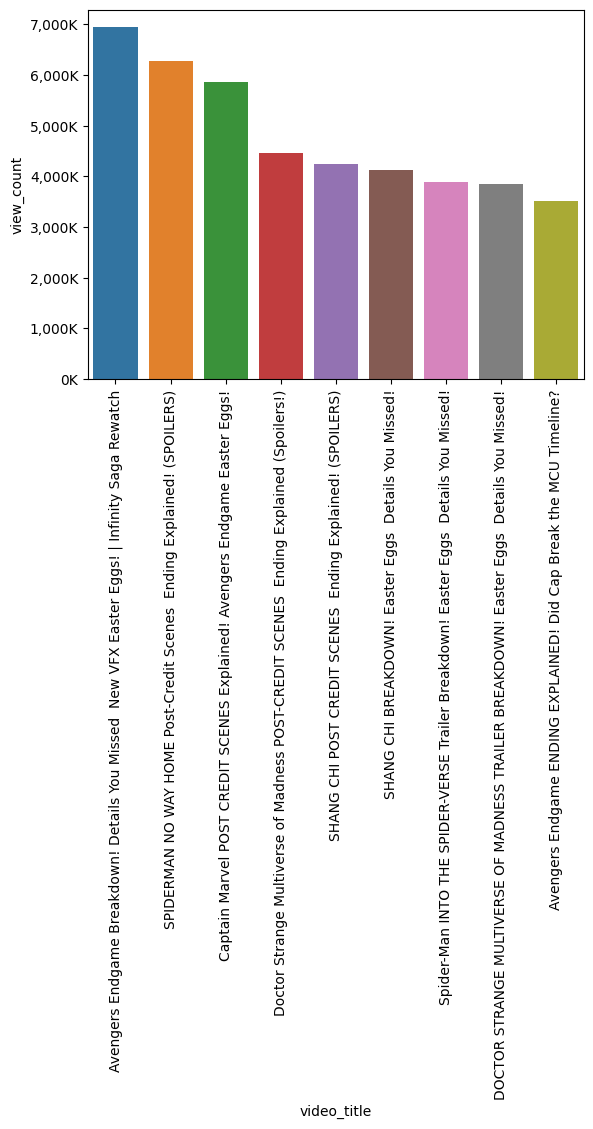

In [54]:
# EDA Bar Chart Visualization of Ten Highest Performing Videos
ax = sns.barplot(x= 'video_title', y='view_count', data=df.sort_values('view_count', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

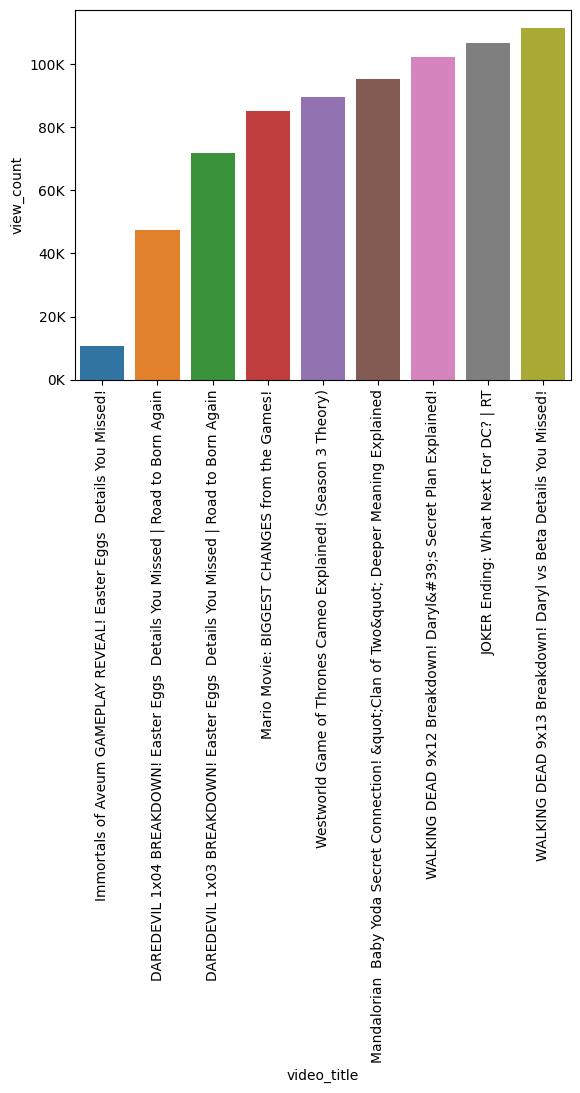

In [55]:
# EDA Bar Chart Visualization of Ten Lowest Performing Videos
ax = sns.barplot(x= 'video_title', y='view_count', data=df.sort_values('view_count', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

A quick note about the above chart: 
At the time of this analysis, the last placed video had just come out, so its view count is necessarily be low. As such, I have included a plot below that eliminates this outlier and adds a tenth. That is one of the advantages and disadvantages of API: you get the most up to date data regardless. 

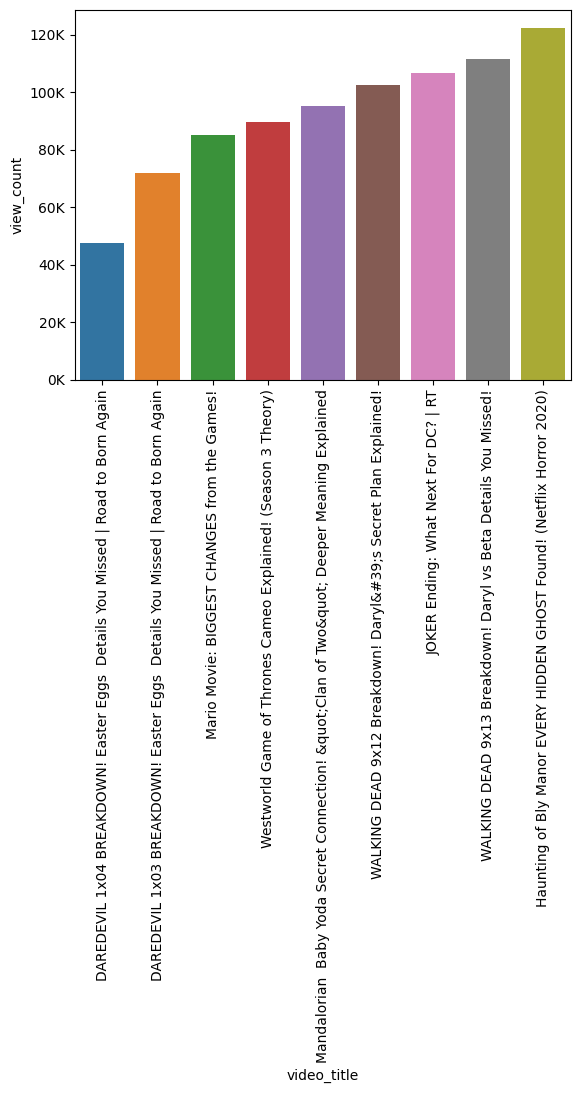

In [56]:
# EDA Bar Chart Visualization of Ten Lowest Performing Videos
ax = sns.barplot(x= 'video_title', y='view_count', data=df.sort_values('view_count', ascending=True)[1:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

<Axes: >

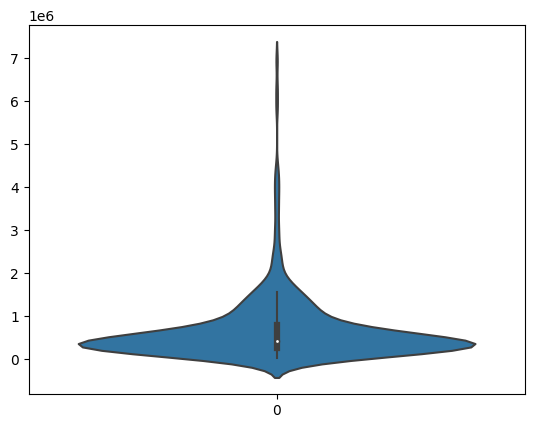

In [57]:
# A violin plot of views -- Note to Jon: add titles
sns.violinplot(df['view_count'])

<Axes: xlabel='like_count', ylabel='view_count'>

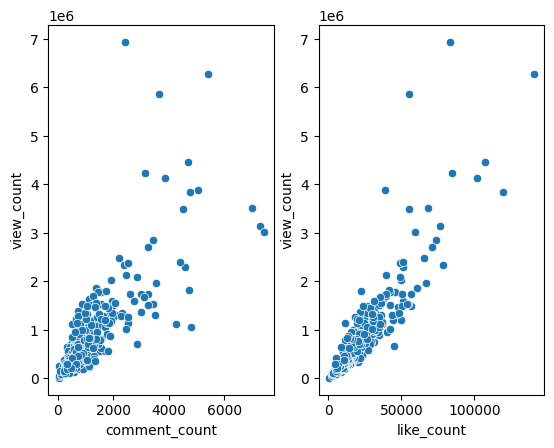

In [58]:
# Scatter plots
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = df, x = 'comment_count', y = 'view_count', ax = ax[0])
sns.scatterplot(data = df, x = 'like_count', y = 'view_count', ax = ax[1])

<Axes: xlabel='duration_secs', ylabel='Count'>

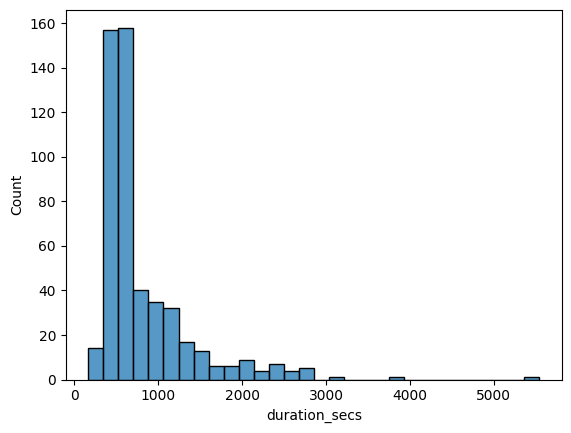

In [59]:
sns.histplot(data = df, x='duration_secs', bins=30)

<Axes: title={'center': 'New Rockstars Yearly Production (to April 2023)'}, xlabel='Year'>

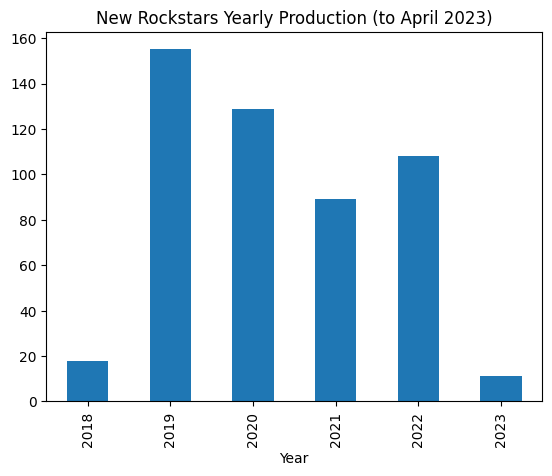

In [60]:
df.groupby('Year').size().plot(kind='bar', title="New Rockstars Yearly Production (to April 2023)")

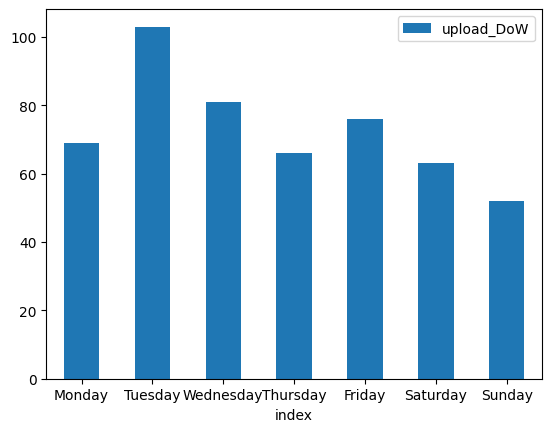

In [61]:
#Upload Schedule
df_day = pd.DataFrame(df['upload_DoW'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_day = df_day.reindex(weekdays)
ax = df_day.reset_index().plot.bar(x = 'index', y = 'upload_DoW', rot = 0)

<Axes: xlabel='Month'>

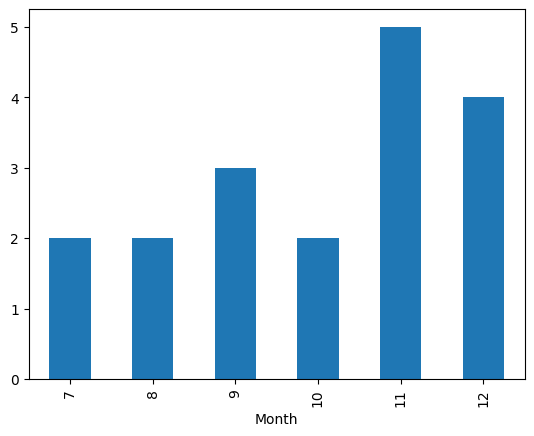

In [62]:
# 2018 Monthly Data
nr_2018_data = df[df['Year']==2018]
nr_2018_data.groupby('Month').size().plot(kind='bar')

<Axes: xlabel='Month'>

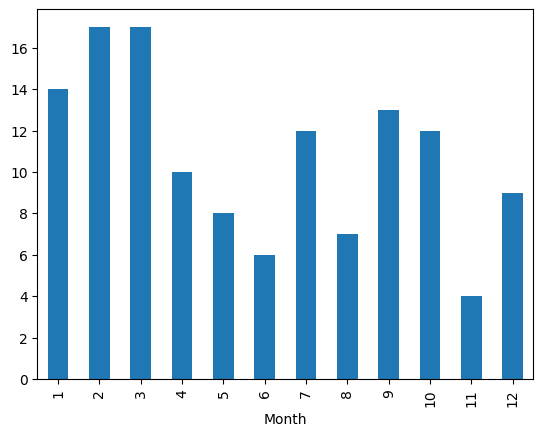

In [63]:
# 2019 Monthly Data
nr_2019_data = df[df['Year']==2020]
nr_2019_data.groupby('Month').size().plot(kind='bar')

<Axes: xlabel='Month'>

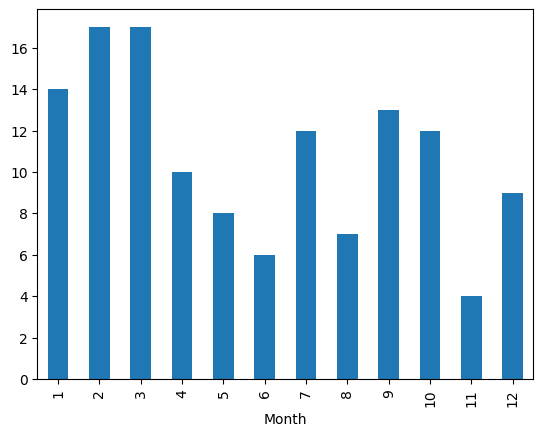

In [64]:
# 2020 Monthly Data
nr_2020_data = df[df['Year']==2020]
nr_2020_data.groupby('Month').size().plot(kind='bar')

<Axes: xlabel='Month'>

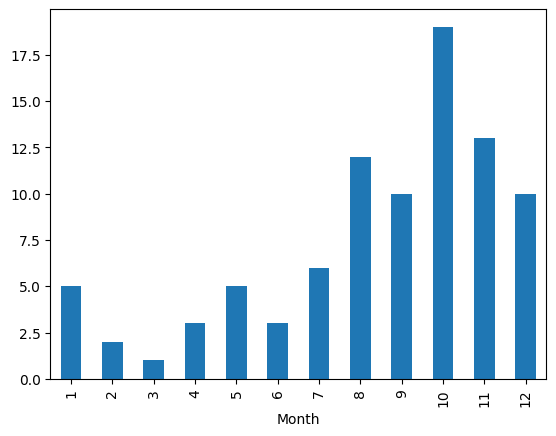

In [65]:
# 2021 Monthly Data
nr_2021_data = df[df['Year']==2021]
nr_2021_data.groupby('Month').size().plot(kind='bar')

<Axes: xlabel='Month'>

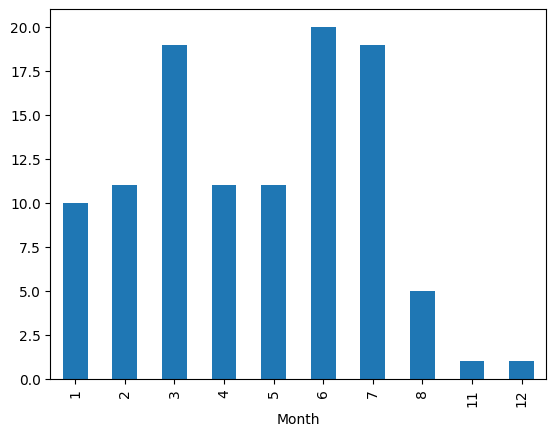

In [66]:
# 2022 Monthly Data
nr_2022_data = df[df['Year']==2022]
nr_2022_data.groupby('Month').size().plot(kind='bar')

<Axes: xlabel='Month'>

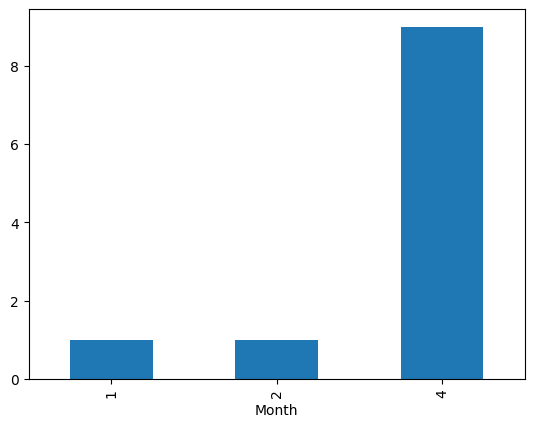

In [67]:
# 2023 Monthly Data
nr_2023_data = df[df['Year']==2023]
nr_2023_data.groupby('Month').size().plot(kind='bar')

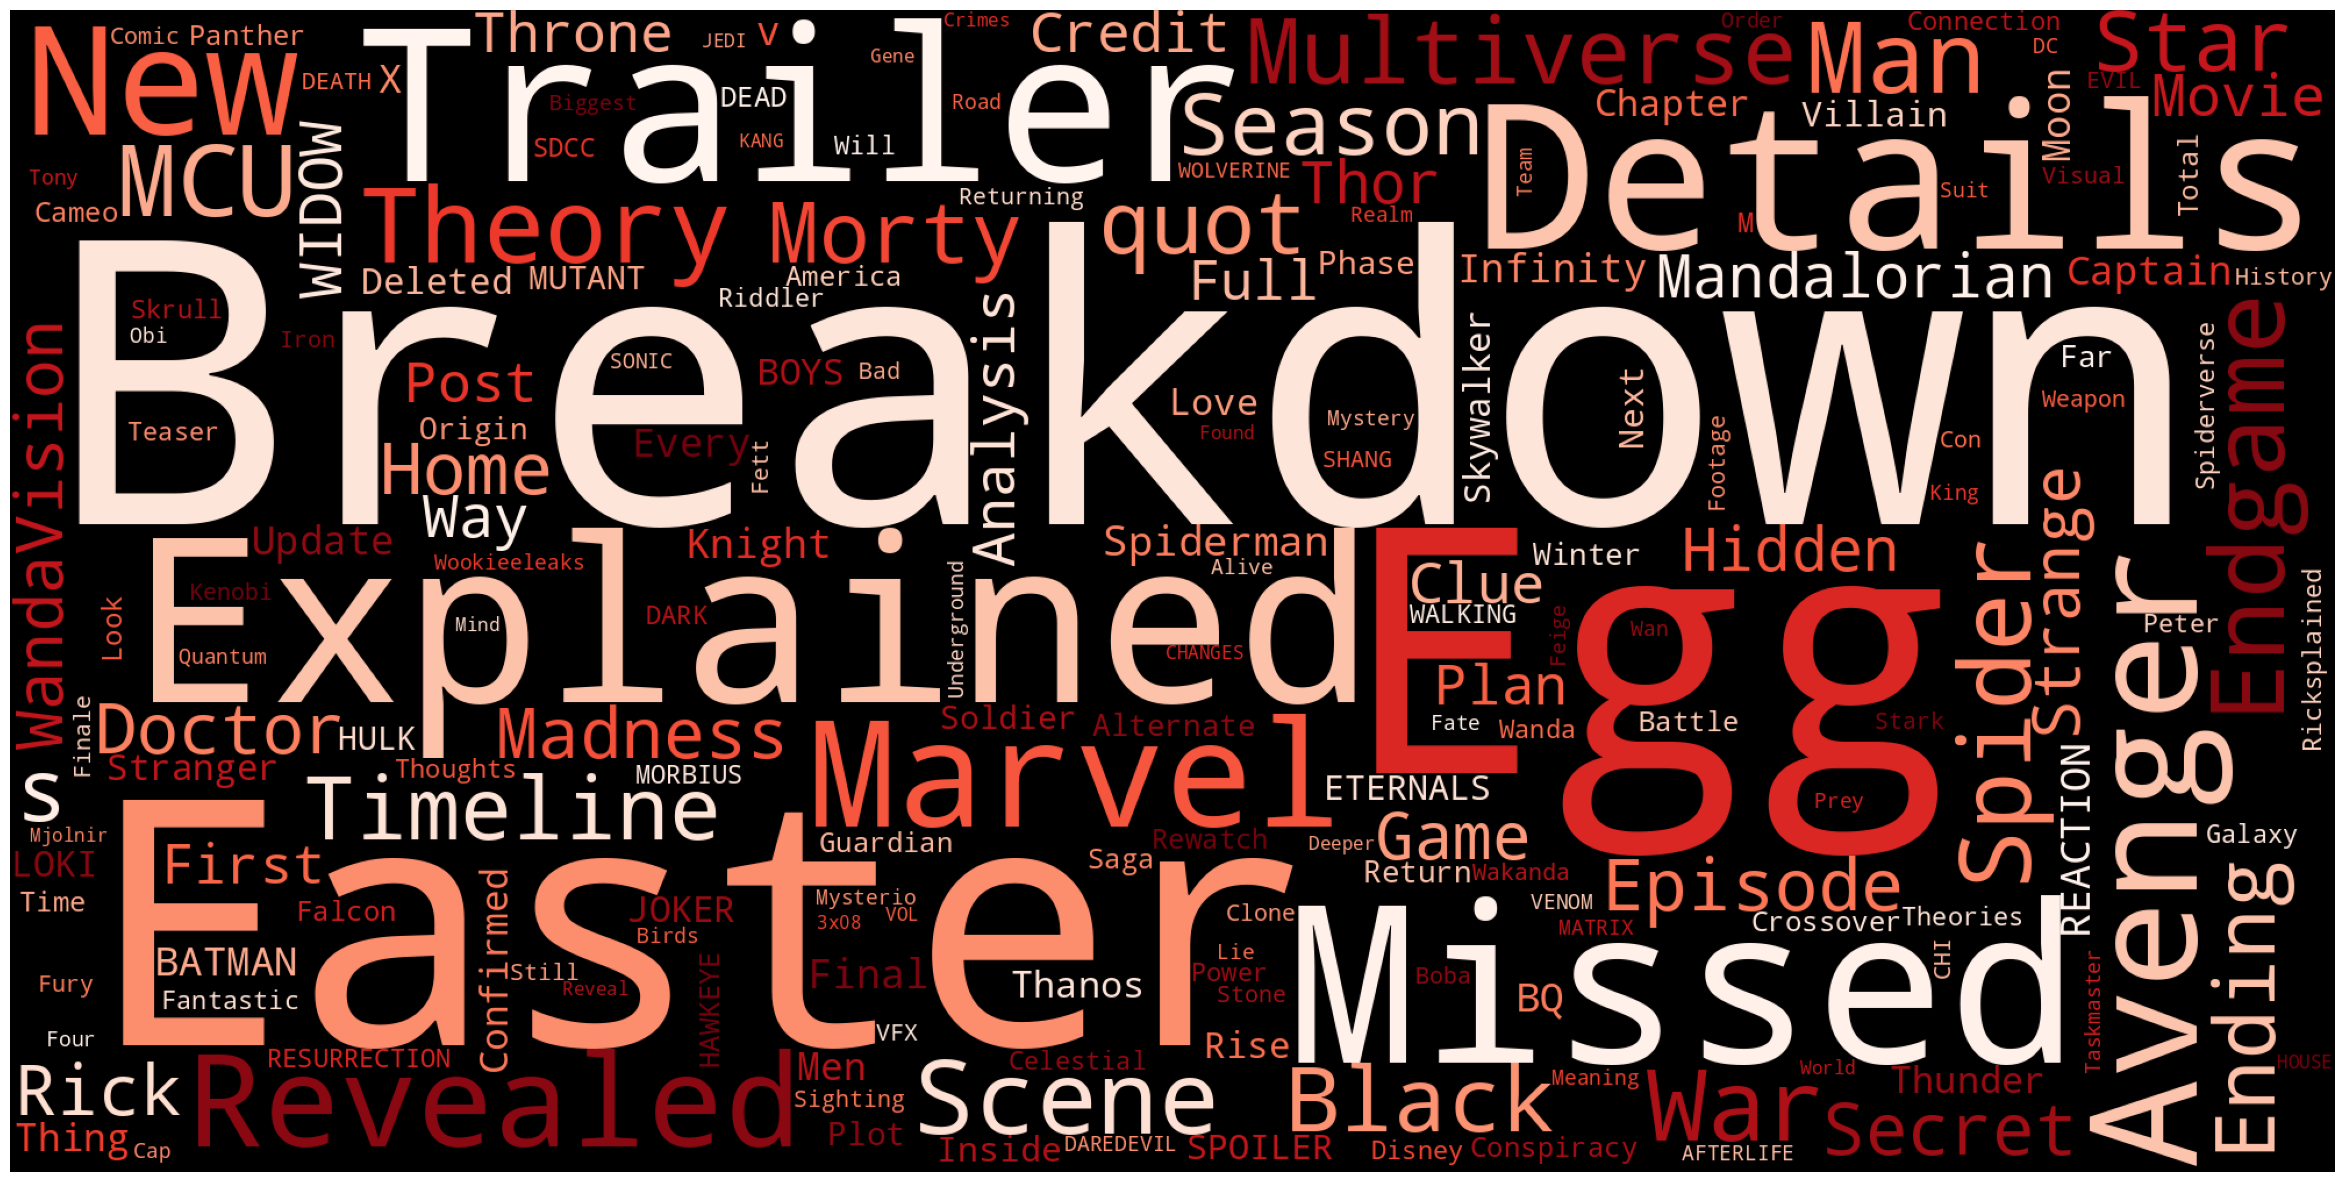

In [68]:
stop_words = set(stopwords.words('english'))
df['title_no_stopwords'] = df['video_title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='Reds', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

##Conclusion

As one might expect, there is a strong positive correlation between view counts and both like and comment counts. This is to be expected, though there does generally appear to be a ceiling on engagement with the channel, outliers not witstanding. The most active upload day of the week is Tuesday, followed closely by Wednesday and Friday. We can see that the production from year to year varies, which makes sense given that a lot of New Rockstars' content will be centered upon things that are current--their releases are going to be closely tired to Hollywood TV and Movie releases. 

In the word cloud, we see that the most promiment terms relate to breakdowns and Easter eggs, along with details that may have been missed in shows or movies. Given the volume of words, it is understandable that no one franchise would be overwhelming, though it is notable how small "DC" is in comparison to other franchies or the representatives thereof. 

###Next Steps

Further exploration of viewer reactions to these videos would be a big step in understanding which content is most attractive and which areas could be further filled out. Given the vicissitudes of Hollywood release schedules (Disney has postponed the release of two or three major entires in the MCU just this year,2023, and has greenlit then canceled more than a few announced Star Wars projects), New Rockstars might consider filling out their offerings with content that is less reactive and more proactive. At present, this is taking the form of the rewatch series with Erik Vos, but could also do a version of breakdowns on Marvel of DC comic events that could factor into future MCU or DCEU films or shows (a similar thing could be done with Star Wars lore, however this would be more difficult given the issues with Legend and Canon and that within current Star Wars canon their are hierarchies of canon: big screen, small screen, then books/comics). 